## Modules à importer

In [180]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools
# from variaIa import tools_ar
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
# from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [270]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'ZTF': plt.cm.viridis(0.1),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nLOWZ = df_nc[df_nc['survey'] != 'LOWZ']
df_nLOWZ_c = df_c[df_c['survey'] != 'LOWZ']
df_full_nLOWZ = df_full.loc[~df_full['survey'].isin(['LOWZ'])]
df_full_ar = df_full.loc[~df_full['survey'].isin(['LOWZ', 'ZTF'])]
df_ar = df_nc[~df_nc['survey'].isin(['LOWZ', 'ZTF'])]
df_ar_c = df_c[~df_c['survey'].isin(['LOWZ', 'ZTF'])]
surveysnl = surveys[0:1]+surveys[3:]

## Définitions des dictionnaires

In [46]:
##############################################################################
############## $z[:z_max]$, $x_1[:z_max]$, data_all, mean et std #############
##############################################################################

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1])
    z_zcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zmax_cuts[survey]]
    x1_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zmax_cuts[survey]]
    c_zcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zmax_cuts[survey]]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])
    
##############################################################################
##################### $[:z_inf]$, $[z_sup:]$ et mean_inf #####################
##############################################################################

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys:
    zinf_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][0])
    z_zinfcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zinf_cuts[survey]]

z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys:
    zsup_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][1])
    z_zsupcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zsup_cuts[survey]]
   
names_sup = []
stretchs_sup = []
stretchs_err_sup = []
colors_sup = []
colors_err_sup = []
redshifts_sup = []

for survey in surveys[1:-1]:
    names_sup += [survey for i in range(len(z_zsupcuts[survey]))] 
    stretchs_sup += list(x1_zsupcuts[survey]) 
    stretchs_err_sup += list(x1_err_zsupcuts[survey]) 
    colors_sup += list(c_zsupcuts[survey]) 
    colors_err_sup += list(c_err_zsupcuts[survey]) 
    redshifts_sup += list(z_zsupcuts[survey]) 

df_sup = pd.DataFrame({'survey': names_sup,
                        'stretchs': stretchs_sup,
                        'stretchs_err': stretchs_err_sup,
                        'colors': colors_sup,
                        'colors_err': colors_err_sup,
                        'redshifts': redshifts_sup})

##############################################################################
########################## $[z_max, inf:z_max, sup]$ #########################
##############################################################################

zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys:
    zbtw_cuts[survey] = np.where((df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][0])
                               & (df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1]))
    z_zbtwcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zbtw_cuts[survey]]

## Tracé des redshifts de l'échantillon choisi

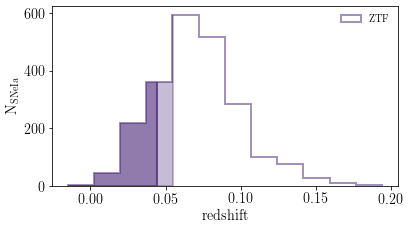

In [24]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

N, _, patches = ax.hist(df_full[df_full['survey'] == tools.su.value].redshifts,
                        bins=12, color=colors[tools.su.value],
                        alpha=.5, histtype='step', lw=2,
                        label=tools.su.value)

xd, xu = ax.get_xlim()

ax.tick_params(labelsize='x-large')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

if not btw.value and not tools.cons.value and not after.value:
    ax.axvspan(np.min(df_full[df_full['survey'] == tools.su.value].redshifts),
               z_max[tools.su.value][1],
               color=colors[tools.su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

if btw.value or (btw.value and tools.cons.value):
    ax.axvspan(np.min(df_full[df_full['survey'] == tools.su.value].redshifts),
               z_max[tools.su.value][0],
               color=colors[tools.su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])
    ax.axvspan(z_max[tools.su.value][0],
               z_max[tools.su.value][1],
               color=colors[tools.su.value],
               alpha=.3, lw=2.0,
               clip_path=patches[0])

if tools.cons.value and not btw.value:
    ax.axvspan(np.min(df_full[df_full['survey'] == tools.su.value].redshifts),
           z_max[tools.su.value][0],
           color=colors[tools.su.value],
           alpha=.6, lw=2.0,
           clip_path=patches[0])

if after.value:
    ax.axvspan(np.min(df_full[df_full['survey'] == tools.su.value].redshifts),
               np.max(df_full[df_full['survey'] == tools.su.value].redshifts),
               color=colors[tools.su.value],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

#ax.set_title(f'Redshift distribution of {survey}', fontsize = 'x-large')

ax.set_xlim([xd, xu])

ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)

path = '../../../Images/pdf/hist_' + tools.su.value + '-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/hist_' + tools.su.value + '-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'
    
path = path + '.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Individual survey

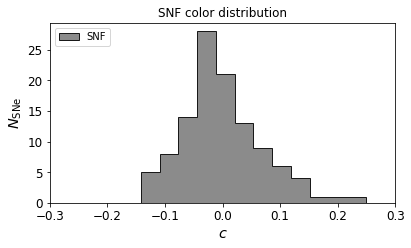

In [26]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop = dict(marker="o", s=20, lw=1)

for survey in surveys[0:1]:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused.colors, bins='auto', density=False,
            histtype='step', fill=True, zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            label=survey)
    
ax.tick_params(labelsize=12)

#ax.set_xlabel(r'$x_1$', fontsize = 'x-large')
ax.set_xlabel(r'$c$', fontsize = 'x-large')
ax.set_ylabel(r'$N_{\mathrm{SNe}}$', fontsize = 'x-large')

#ax.set_xlim(-3, 3)
ax.set_xlim(-0.3, 0.3)
# for legend between
#ax.set_ylim(0, 1)

ax.legend(loc='upper left', fontsize='medium', ncol=5)
#plt.title('PS1 and SDSS stretch distributions for 0.10 < z < 0.15')
#plt.title('PS1 and SDSS stretch distributions for 0.15 < z < 0.20')
plt.title('SNF color distribution')
#plt.title('PS1 and SDSS color distributions for 0.15 < z < 0.20')

#path = '../../Images/pdf/stretchs-cut'
path = '../../Images/pdf/colors-cut'
path = path + '_SNF.pdf'
#path = path + '_SDSS_PS1-015-020.pdf'
fig.savefig(path, bbox_inches='tight')

#path = '../../Images/png/stretchs-cut'
path = '../../Images/png/colors-cut'
path = path + '_SNF.png'
#path = path + '_SDSS_PS1-015-020.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé total : histogrammes

### Vert

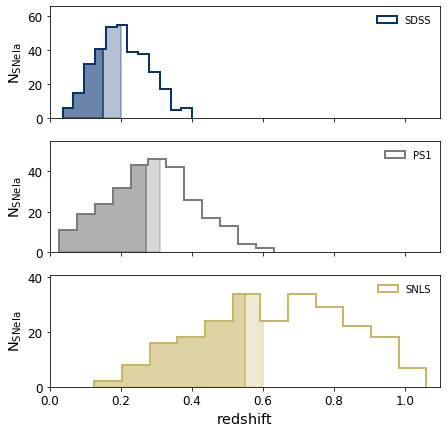

In [31]:
fig = plt.figure(figsize=[7, 7])
#fig = plt.figure(figsize=[15, 3])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

i = 1

for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    N, _, patches = ax.hist(surv[survey].zCMB, bins=nb_x.value,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    
    if not btw.value and not cons.value and not after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    if btw.value or (btw.value and cons.value):
        ax.axvspan(np.min(surv[survey].zCMB),
                   z_max[survey][0],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    if cons.value and not btw.value:
        ax.axvspan(np.min(surv[survey].zCMB),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

    if after.value:
        ax.axvspan(np.min(surv[survey].zCMB),
                   np.max(surv[survey].zCMB),
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    
    if i == 3:
        ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    else:
        ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    #if i == 1:
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    ax.tick_params(labelsize = 12)
    #if i >= 2:
    #    ax.set_yticks([])
    
    ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)
    i += 1

#fig.savefig('../../Images/pdf/hist_surveys_cuts_75-'+smap.name+'.pdf', bbox_inches='tight')
#fig.savefig('../../Images/png/hist_surveys_cuts_75-'+smap.name+'.png', bbox_inches='tight', dpi=600)

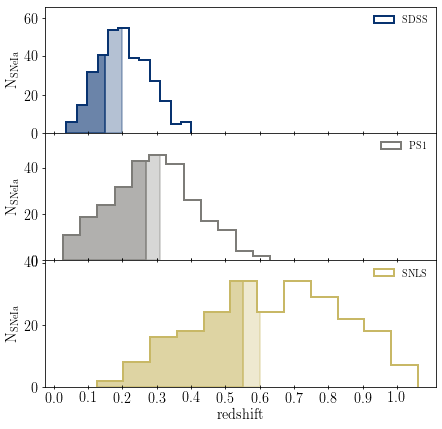

In [258]:
fig = plt.figure(figsize=[7, 7], constrained_layout=False)
gs = fig.add_gridspec(3, 1, hspace=0.00)
axd = gs.subplots(sharex='col')

nb_x = 12

for i, survey in enumerate(surveysnl[1:-1]):
    ax = axd[i]
    N, _, patches = ax.hist(df_full.loc[df_full['survey'] == survey].redshifts,
                            bins=nb_x,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    
    if not btw.value and not tools.cons.value and not after.value:
        ax.axvspan(np.min(df_full.loc[df_full['survey'] == survey].redshifts),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    if btw.value or (btw.value and tools.cons.value):
        ax.axvspan(np.min(df_full.loc[df_full['survey'] == survey].redshifts),
                   z_max[survey][0],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    if tools.cons.value and not btw.value:
        ax.axvspan(np.min(df_full.loc[df_full['survey'] == survey].redshifts),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

    if after.value:
        ax.axvspan(np.min(df_full.loc[df_full['survey'] == survey].redshifts),
                   np.max(df_full.loc[df_full['survey'] == survey].redshifts),
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    # ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    if i > 0:
        ax.tick_params(axis='x', top=True, direction='inout')
    if i == 2:
        ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    ax.tick_params(labelsize='x-large')
    
    ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)

fig.savefig('../../../Images/pdf/hist_surveys_cuts_nospace.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/hist_surveys_cuts_nospace.png', bbox_inches='tight', dpi=600)

### To please Yannick

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


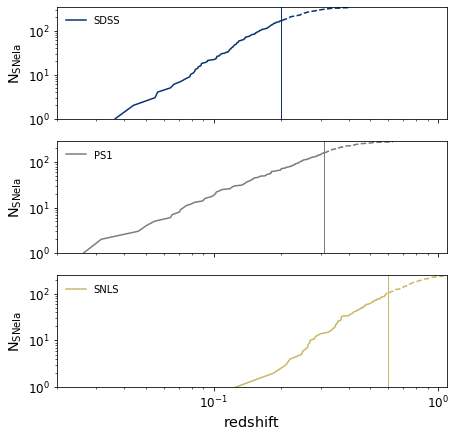

In [57]:
fig = plt.figure(figsize=[7, 7])
#fig = plt.figure(figsize=[15, 3])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

z_sorted = {survey: np.sort(df_full[df_full['survey'] == survey].redshifts)
           for survey in surveys[1:-1]}
counts = {survey: np.asarray([(i+1) for i in range(len(z_sorted[survey]))]).T
         for survey in surveys[1:-1]}

i = 1

for survey in surveysnl[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    where_low = z_sorted[survey] < z_max[survey][-1]
    ax.plot(z_sorted[survey][where_low],
            counts[survey][where_low],
            color=colors[survey],
            label=survey)
    
    ax.axvline(z_max[survey][-1],
               color=colors[survey],
               lw=1)
    
    ax.plot(z_sorted[survey][~where_low],
            counts[survey][~where_low],
            color=colors[survey],
            ls='--')

    ax.set_xlim(0.02, 1.1)
    ax.set_ylim(bottom=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if i == 3:
        ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    else:
        ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    #if i == 1:
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    ax.tick_params(labelsize = 12)
    #if i >= 2:
    #    ax.set_yticks([])
    
    ax.legend(ncol=1, loc='upper left', fontsize='medium', frameon=False)
    i += 1

fig.savefig('../../../Images/pdf/hist_unbinned_surveys_cut_77-'+smap.name+'.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/hist_unbinned_surveys_cut_77-'+smap.name+'.png', bbox_inches='tight', dpi=600)

### Horiz

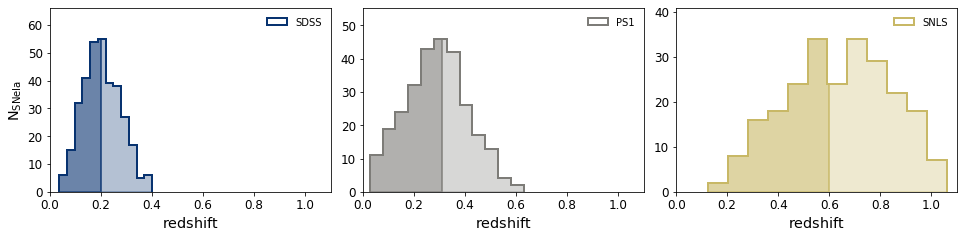

In [10]:
#fig = plt.figure(figsize=[5, 5])
fig = plt.figure(figsize=[15, 3])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)
dgmap = plt.cm.get_cmap('viridis')

i = 1

# for vert
#left, width = 0.1, 0.85
#bottom, height = 0.11, 0.26
#yspan = 0.03

# for horiz
left, width = 0.1, 0.26
bottom, height = 0.11, 0.85
xspan = 0.03

for i, survey in enumerate(surveys[1:-1]):#[::-1]):
    # for vert
    #ax = fig.add_axes([left, bottom+i*(height+yspan), width, height])
    # for horiz
    ax = fig.add_axes([left+i*(width+xspan), bottom, width, height])
    N, _, patches = ax.hist(df_full[df_full['survey'] == survey].redshifts, bins=12,
                            color=colors[survey],
                            histtype='step', lw=2, label=survey)
    if not btw.value and not tools_ar.cons.value and not after.value:
        ax.axvspan(np.min(df_full[df_full['survey'] == survey].redshifts),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])

    if btw.value or (btw.value and tools_ar.cons.value):
        ax.axvspan(np.min(df_full[df_full['survey'] == survey].redshifts),
                   z_max[survey][0],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    if tools_ar.cons.value and not btw.value:
        ax.axvspan(np.min(df_full[df_full['survey'] == survey].redshifts),
               z_max[survey][0],
               color=colors[survey],
               alpha=.6, lw=2.0,
               clip_path=patches[0])

    if after.value:
        ax.axvspan(np.min(df_full[df_full['survey'] == survey].redshifts),
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.6, lw=2.0,
                   clip_path=patches[0])
        
        ax.axvspan(z_max[survey][1],
                   np.max(df_full[df_full['survey'] == survey].redshifts),
                   color=colors[survey],
                   alpha=.3, lw=2.0,
                   clip_path=patches[0])

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.20*np.max(N))
    
    #if i == 0:
    ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
    #else:
    #    ax.set_xticklabels(['' for _ in ax.get_xticklabels()])
    if i == 0:
        ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    #if i >= 2:
    #    ax.set_yticks([])
    
    ax.tick_params(labelsize = 12)
    ax.legend(ncol=1, loc='upper right', fontsize='medium', frameon=False)

path = '../../../Images/pdf/hist_surveys_horiz'
if tools_ar.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '-' + smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/hist_surveys_horiz'
if tools_ar.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '-' + smap.name+'.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Combined, stacked hist only

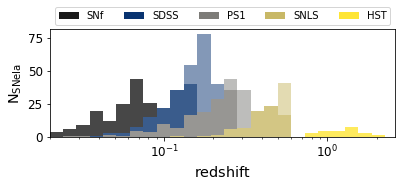

In [29]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.3])

prop = dict(marker="o", s=20, lw=1)

test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]]
                 for survey in surveysnl],
                dtype=object)

it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
stacked = np.array([test[i][k] for i,k in it], dtype=object)
hstclrs = [[alphacolors(.5, survey),
            alphacolors(.8, survey)] for survey in surveysnl]
hstclrs = [item for sublist in hstclrs for item in sublist]

order = [3, 2, 1, 0, 4]
stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
hstclrs_bt = [alphacolors(.8, surveysnl[i]) for i in order]\
           + [alphacolors(.5, surveysnl[i]) for i in order]

logbins = 10**np.linspace(np.log10(np.min(df_nc.redshifts)),
                          np.log10(np.max(df_nc.redshifts)), 30)

ax.hist(stacked_bt,
        stacked=True,
        bins=logbins,
        histtype='stepfilled',
        color=hstclrs_bt)

ax.hist([-1, -1, -1], color=colors['SNF'], label='SNf')
for survey in surveysnl[1:]:
    ax.hist([-1, -1, -1], color=colors[survey], label=survey)

ax.legend(loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.25, 0.0, 0.00))

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.set_xlim(0.02, 2.6)
ax.set_xscale('log')

#from matplotlib.lines import Line2D

#SNfleg = Line2D([0], [0], color=colors['SNF'], linewidth=0, marker='o')
#SDSSleg = Line2D([0], [0], color=colors['SDSS'], linewidth=0, marker='o')
#PS1leg = Line2D([0], [0], color=colors['PS1'], linewidth=0, marker='o')
#SNLSleg = Line2D([0], [0], color=colors['SNLS'], linewidth=0, marker='o')
#HSTleg = Line2D([0], [0], color=colors['HST'], linewidth=0, marker='o')
#labels = ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST']

#ax.legend((SNfleg, SDSSleg, PS1leg, SNLSleg, HSTleg),
#          labels,
#          loc='upper center', fontsize='medium', ncol=5,
#          bbox_to_anchor=(0.5, 1.25, 0.0, 0.00))


path = '../../../Images/pdf/hist_surveys'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_stac_'+smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/hist_surveys'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_stac_'+smap.name+'.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé total : $x_1$ at zmax_cons, btw, sup

In [43]:
surveysnl

['SNF', 'LOWZ', 'SDSS', 'PS1', 'SNLS', 'HST']

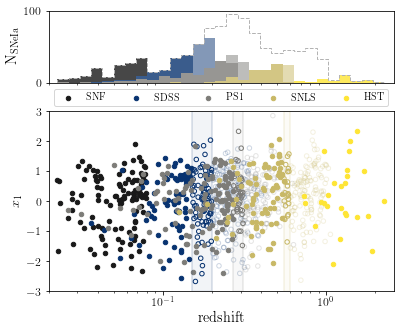

In [74]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
# for legend between
ax2 = fig.add_axes([0.1, 0.70, 0.6, 0.2])
# for legend down
#ax2 = fig.add_axes([0.1, 0.65, 0.6, 0.2])

prop = dict(marker="o", s=20, lw=1)

#_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in surveysnl:
    df_arused = df_ar[df_ar['survey'] == survey]
    df_ar_cused = df_ar_c[df_ar_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **prop, alpha=.2)

# Define order in which to plot the stacked histograms
order = [3, 2, 1, 0, 4]

if btw.value:
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]]
                     for survey in surveysnl],
                    dtype=object)
    
    it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in surveysnl]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
    hstclrs_bt = [alphacolors(.8, surveysnl[i]) for i in order]\
               + [alphacolors(.5, surveysnl[i]) for i in order]
    
    logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
                              np.log10(np.max(df_ar.redshifts)), 30)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt)
    
if after.value:
    # test = np.array([[z_zcuts[survey], z_zsupcuts[survey]]
    #                  for survey in surveysnl],
    #                 dtype=object)
    # 
    # it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    # stacked = np.array([test[i][k] for i,k in it], dtype=object)
    # hstclrs = [[alphacolors(.5, survey),
    #             alphacolors(.8, survey)] for survey in surveysnl]
    # hstclrs = [item for sublist in hstclrs for item in sublist]
    # 
    # stacked_af = [test[i][0] for i in order] + [test[i][1] for i in order]
    # hstclrs_af = [alphacolors(.8, surveysnl[i]) for i in order]\
    #            + [alphacolors(.5, surveysnl[i]) for i in order]
    # 
    # logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
    #                           np.log10(np.max(df_ar.redshifts)), 30)
    # 
    # ax2.hist(stacked_af,
    #          stacked=True,
    #          bins=logbins,
    #          histtype='stepfilled',
    #          color=hstclrs_af)
    ax2.hist(df_full_ar.redshifts,
             bins=logbins,
             histtype='step',
             ls='--', lw=1, color='0.7')
    
if (not(btw.value) and not(after.value)):
    stacked = [z_zcuts[surveysnl[i]] for i in order]
    hstclrs = [alphacolors(.8, surveysnl[i]) for i in order]
    logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
                              np.log10(np.max(df_ar.redshifts)), 30)
    
    ax2.hist(stacked,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs)
    
ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')
ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.set_xlim(0.02, 2.6)
# for legend between
ax.set_ylim(-3, 3)
# for legend down
#ax.set_ylim(-3.6, 3)
ax.set_xscale('log')

ax2.set_xlim(0.02, 2.6)
ax2.set_xscale('log')
ax2.get_xaxis().set_ticks([])

from matplotlib.lines import Line2D

SNfleg = Line2D([0], [0], color=colors['SNF'],linewidth=0, marker='o')
SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='o')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='o')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='o')
HSTleg = Line2D([0], [0], color=colors['HST'],linewidth=0, marker='o')
labels = ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST']

# for figsize(7,5), legend between
ax.legend(loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))
# for figsize(7,5), legend down
#ax.legend(loc='lower center', fontsize='medium', ncol=5)

path = '../../../Images/pdf/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.png'
# fig.savefig(path, bbox_inches='tight', dpi=600)

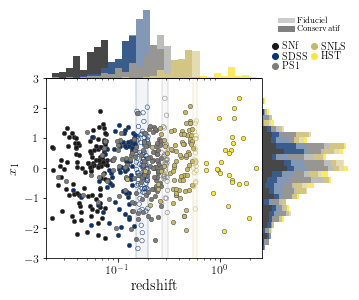

In [288]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
ax2 = fig.add_axes([0.1, 0.62, 0.6, 0.2])
ax3 = fig.add_axes([0.7, 0.12, 0.25, 0.5])

prop = dict(marker="o", s=20, lw=0.5)
propaf = dict(marker=".", s=10, lw=1)

for survey in surveysnl:
    df_arused = df_ar[df_ar['survey'] == survey]
    df_ar_cused = df_ar_c[df_ar_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey], 
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   edgecolors='0.3',
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **propaf, alpha=.2)


if btw.value:
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]]
                     for survey in surveysnl],
                    dtype=object)
    
    # Define order in which to plot the stacked histograms
    order = [3, 2, 1, 0, 4]
    
    it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in surveysnl]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
    hstclrs_bt = [alphacolors(.8, surveysnl[i]) for i in order]\
               + [alphacolors(.5, surveysnl[i]) for i in order]
    
    logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
                              np.log10(np.max(df_ar.redshifts)), 30)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt)
    
    test = np.array([[x1_zinfcuts[survey], x1_zbtwcuts[survey]]
                     for survey in surveysnl],
                    dtype=object)
    
    # Define order in which to plot the stacked histograms
    order = [0, 1, 2, 3, 4]
    
    it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.8, survey),
                alphacolors(.5, survey)] for survey in surveysnl]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    xbins = np.linspace(df_full_ar.stretchs.min(),
                        df_full_ar.stretchs.max(), 30)
    
    ax3.hist(stacked,
             stacked=True,
             orientation='horizontal',
             bins=xbins,
             histtype='stepfilled',
             color=hstclrs)
    
if after.value:
    # test = np.array([[z_zcuts[survey], z_zsupcuts[survey]]
    #                  for survey in surveysnl],
    #                 dtype=object)
    # 
    # it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    # stacked = np.array([test[i][k] for i,k in it], dtype=object)
    # hstclrs = [[alphacolors(.5, survey),
    #             alphacolors(.8, survey)] for survey in surveysnl]
    # hstclrs = [item for sublist in hstclrs for item in sublist]
    # 
    # stacked_af = [test[i][0] for i in order] + [test[i][1] for i in order]
    # hstclrs_af = [alphacolors(.8, surveysnl[i]) for i in order]\
    #            + [alphacolors(.5, surveysnl[i]) for i in order]
    # 
    # logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
    #                           np.log10(np.max(df_ar.redshifts)), 30)
    # 
    # ax2.hist(stacked_af,
    #          stacked=True,
    #          bins=logbins,
    #          histtype='stepfilled',
    #          color=hstclrs_af)
    ax2.hist(df_full_ar.redshifts,
             bins=logbins,
             histtype='step',
             ls='--', lw=1, color='0.7')
    ax3.hist(df_full_ar.stretchs,
             orientation='horizontal',
             bins=xbins,
             histtype='step',
             lw=1, ls='--',
             color='0.7')
    
if (not(btw.value) and not(after.value)):
    stacked = [z_zcuts[surveysnl[i]] for i in order]
    hstclrs = [alphacolors(.8, surveysnl[i]) for i in order]
    logbins = 10**np.linspace(np.log10(np.min(df_ar.redshifts)),
                              np.log10(np.max(df_ar.redshifts)), 30)
    
    ax2.hist(stacked,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs)
    
ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_xlim(0.02, 2.6)
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylim(-3, 3)
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.legend()

ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
    
from matplotlib.lines import Line2D

SNfleg = Line2D([0], [0], color=colors['SNF'],linewidth=0, marker='o')
SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='o')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='o')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='o')
HSTleg = Line2D([0], [0], color=colors['HST'],linewidth=0, marker='o')
leg_scat = [SNfleg, SDSSleg, PS1leg, SNLSleg, HSTleg]
lab_scat = ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST']

ax.legend(leg_scat, lab_scat,
          loc='upper center', fontsize='medium', ncol=2,
          bbox_to_anchor=(1.2, 1.1, 0.0, 0.15),
          columnspacing=-0.2, labelspacing=0.1,
          handletextpad=-0.3, scatterpoints=1,
          frameon=False).set_zorder(100)

from matplotlib.patches import Patch
fidu_leg = Patch(facecolor='.8')
cons_leg = Patch(facecolor='.5')
full_leg = Patch(facecolor='none', edgecolor='0.7', ls='--')
if after.value:
    leg_hist = [full_leg, fidu_leg, cons_leg]
    lab_hist = ['Coupé', 'Fiduciel', 'Conservatif']
    bbox = (1.22, 0.9, 0.0, 0.15)
else:
    leg_hist = [fidu_leg, cons_leg]
    lab_hist = ['Fiduciel', 'Conservatif']
    bbox = (1.22, 0.8, 0.0, 0.15)
ax2.legend(leg_hist, lab_hist,
           loc='upper center', fontsize='small', ncol=1,
           bbox_to_anchor=bbox,
           columnspacing=-0.2, labelspacing=0.1,
           handletextpad=.3, scatterpoints=1,
           frameon=False)

path = '../../../Images/pdf/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_x1.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_x1.png'
# fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé AVEC ZTF

In [262]:
surveysaz

['SNF', 'ZTF', 'SDSS', 'PS1', 'SNLS', 'HST']

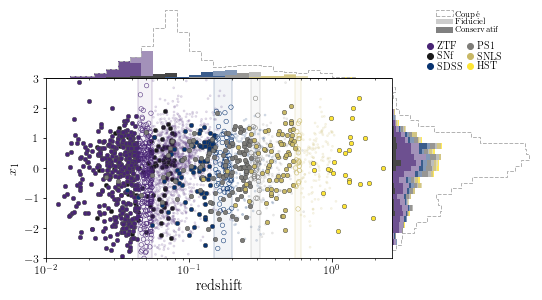

In [286]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
ax2 = fig.add_axes([0.1, 0.62, 0.6, 0.2])
ax3 = fig.add_axes([0.7, 0.12, 0.25, 0.5])

prop = dict(marker="o", s=20, lw=0.5)
propaf = dict(marker=".", s=10, lw=1)
surveysaz = surveys[:2]+surveys[3:]
xmin = 0.01
xmax = 2.6
for survey in surveysaz:
    df_nLOWZused = df_nLOWZ[df_nLOWZ['survey'] == survey]
    df_nLOWZ_cused = df_nLOWZ_c[df_nLOWZ_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey], 
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   edgecolors='0.3',
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **propaf, alpha=.2)


if btw.value:
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]]
                     for survey in surveysaz],
                    dtype=object)
    
    # Define order in which to plot the stacked histograms
    order = [4, 3, 2, 0, 1, 5]
    
    it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1),
          (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in surveysaz]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
    hstclrs_bt = [alphacolors(.8, surveysaz[i]) for i in order]\
               + [alphacolors(.5, surveysaz[i]) for i in order]
    
    logbins = 10**np.linspace(np.log10(xmin),
                              np.log10(xmax), 30)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt)
    
    test = np.array([[x1_zinfcuts[survey], x1_zbtwcuts[survey]]
                     for survey in surveysaz],
                    dtype=object)
    
    # Define order in which to plot the stacked histograms
    order = [1, 0, 2, 3, 4, 5]
    
    it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1),
          (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.8, survey),
                alphacolors(.5, survey)] for survey in surveysaz]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    xbins = np.linspace(df_full_nLOWZ.stretchs.min(),
                        df_full_nLOWZ.stretchs.max(), 30)
    
    ax3.hist(stacked,
             stacked=True,
             orientation='horizontal',
             bins=xbins,
             histtype='stepfilled',
             color=hstclrs)
    
if after.value:
    # test = np.array([[z_zcuts[survey], z_zsupcuts[survey]]
    #                  for survey in surveysaz],
    #                 dtype=object)
    # 
    # it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
    # stacked = np.array([test[i][k] for i,k in it], dtype=object)
    # hstclrs = [[alphacolors(.5, survey),
    #             alphacolors(.8, survey)] for survey in surveysaz]
    # hstclrs = [item for sublist in hstclrs for item in sublist]
    # 
    # stacked_af = [test[i][0] for i in order] + [test[i][1] for i in order]
    # hstclrs_af = [alphacolors(.8, surveysaz[i]) for i in order]\
    #            + [alphacolors(.5, surveysaz[i]) for i in order]
    # 
    # logbins = 10**np.linspace(np.log10(np.min(df_nLOWZ.redshifts)),
    #                           np.log10(np.max(df_nLOWZ.redshifts)), 30)
    # 
    # ax2.hist(stacked_af,
    #          stacked=True,
    #          bins=logbins,
    #          histtype='stepfilled',
    #          color=hstclrs_af)
    ax2.hist(df_full_nLOWZ.redshifts,
             bins=logbins,
             histtype='step',
             ls='--', lw=1, color='0.7')
    ax3.hist(df_full_nLOWZ.stretchs,
             orientation='horizontal',
             bins=xbins,
             histtype='step',
             lw=1, ls='--',
             color='0.7')
    
if (not(btw.value) and not(after.value)):
    stacked = [z_zcuts[surveysaz[i]] for i in order]
    hstclrs = [alphacolors(.8, surveysaz[i]) for i in order]
    logbins = 10**np.linspace(np.log10(np.min(df_nLOWZ.redshifts)),
                              np.log10(np.max(df_nLOWZ.redshifts)), 30)
    
    ax2.hist(stacked,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs)
    
ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylim(-3, 3)
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.legend()

ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
    
from matplotlib.lines import Line2D

ZTFleg = Line2D([0], [0], color=colors['ZTF'],linewidth=0, marker='o')
SNfleg = Line2D([0], [0], color=colors['SNF'],linewidth=0, marker='o')
SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='o')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='o')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='o')
HSTleg = Line2D([0], [0], color=colors['HST'],linewidth=0, marker='o')
leg_scat = [ZTFleg, SNfleg, SDSSleg, PS1leg, SNLSleg, HSTleg]
lab_scat = ['ZTF', 'SNf', 'SDSS', 'PS1', 'SNLS', 'HST']

ax.legend(leg_scat, lab_scat,
          loc='upper center', fontsize='medium', ncol=2,
          bbox_to_anchor=(1.2, 1.1, 0.0, 0.15),
          columnspacing=-0.2, labelspacing=0.1,
          handletextpad=-0.3, scatterpoints=1,
          frameon=False).set_zorder(100)

from matplotlib.patches import Patch
fidu_leg = Patch(facecolor='.8')
cons_leg = Patch(facecolor='.5')
full_leg = Patch(facecolor='none', edgecolor='0.7', ls='--')
if after.value:
    leg_hist = [full_leg, fidu_leg, cons_leg]
    lab_hist = ['Coupé', 'Fiduciel', 'Conservatif']
    bbox = (1.22, 0.9, 0.0, 0.15)
else:
    leg_hist = [fidu_leg, cons_leg]
    lab_hist = ['Fiduciel', 'Conservatif']
    bbox = (1.22, 0.8, 0.0, 0.15)
ax2.legend(leg_hist, lab_hist,
           loc='upper center', fontsize='small', ncol=1,
           bbox_to_anchor=bbox,
           columnspacing=-0.2, labelspacing=0.1,
           handletextpad=.3, scatterpoints=1,
           frameon=False)

path = '../../../Images/pdf/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_ztf_x1.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stacz_x1.png'
# fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé pour ZTF

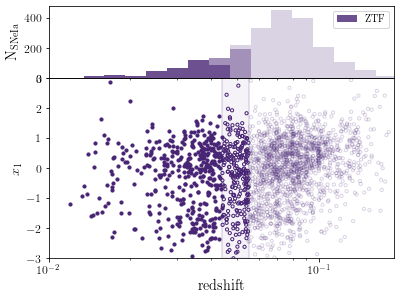

In [63]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
# for legend between
ax2 = fig.add_axes([0.1, 0.62, 0.6, 0.2])
# for legend down
#ax2 = fig.add_axes([0.1, 0.65, 0.6, 0.2])

prop = dict(marker="o", s=10, lw=1)

#_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in ['ZTF']:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **prop, alpha=.2)

if btw.value:
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey], z_zsupcuts[survey]]
                     for survey in ['ZTF']],
                    dtype=object)
    
    it = [(0, 0), (0, 1), (0, 2)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.2, survey),
                alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in ['ZTF']]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[0][0]] + [test[0][1]] + [test[0][2]] 
    hstclrs_bt = [alphacolors(.8, ['ZTF'][0])]\
               + [alphacolors(.5, ['ZTF'][0])]\
               + [alphacolors(.2, ['ZTF'][0])]
    
    df_used = df_full.loc[df_full['survey'] == 'ZTF']
    logbins = 10**np.linspace(np.log10(np.min(df_used.redshifts)),
                              np.log10(np.max(df_used.redshifts)), 30)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt,
             label='ZTF')
    
# if after.value:
#     test = np.array([[z_zcuts[survey], z_zsupcuts[survey]]
#                      for survey in ['ZTF']],
#                     dtype=object)
#     
#     it = [(0, 0), (0, 1)]
#     stacked = np.array([test[i][k] for i,k in it], dtype=object)
#     hstclrs = [[alphacolors(.5, survey),
#                 alphacolors(.8, survey)] for survey in ['ZTF']]
#     hstclrs = [item for sublist in hstclrs for item in sublist]
#     
#     stacked_af = [test[0][0]] + [test[0][1]]
#     hstclrs_af = [alphacolors(.8, ['ZTF'][0])]\
#                + [alphacolors(.5, ['ZTF'][0])]
#     
#     ax2.hist(stacked_af,
#              stacked=True,
#              bins=logbins,
#              histtype='step',
#              lw=2,
#              color=hstclrs_af)
    # ax2.hist(df_full.redshifts,
    #         bins=logbins,
    #         histtype='step', lw=2,
    #          color=colors[survey])

ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_xlim(0.01,
            0.19)
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylim(-3, 3)
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])
ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax2.legend()

path = '../../../Images/pdf/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_ztf.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_ztf.pdf'
# fig.savefig(path, bbox_inches='tight', dpi=600)

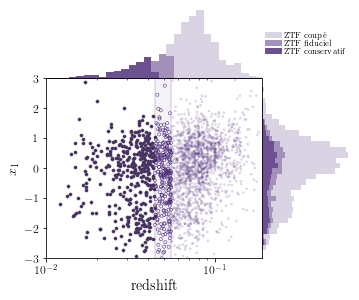

In [290]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
ax2 = fig.add_axes([0.1, 0.62, 0.6, 0.2])
ax3 = fig.add_axes([0.7, 0.12, 0.25, 0.5])

prop = dict(marker="o", s=10, lw=0.5)
propaf = dict(marker=".", s=10, lw=1)

for survey in ['ZTF']:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   x1_zinfcuts[survey],
                   color=colors[survey],
                   edgecolors='0.3',
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   x1_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   x1_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   x1_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **propaf, alpha=.2)

xbins = 30
if (btw.value) and not (after.value):
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]]
                     for survey in ['ZTF']],
                    dtype=object)
    
    it = [(0, 0), (0, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in ['ZTF']]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[0][0]] + [test[0][1]]
    hstclrs_bt = [alphacolors(.8, ['ZTF'][0])]\
               + [alphacolors(.5, ['ZTF'][0])]
    
    df_used = df_nc.loc[df_nc['survey'] == 'ZTF']
    logbins = 10**np.linspace(np.log10(0.01),
                              np.log10(np.max(df_used.redshifts)), 20)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt,
             label=['ZTF conservatif', 'ZTF fiduciel', 'ZTF coupé'])
    test = np.array([[x1_zinfcuts[survey], x1_zbtwcuts[survey]]
                     for survey in ['ZTF']],
                    dtype=object)
    
    it = [(0, 0), (0, 1)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[ alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in ['ZTF']]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[0][0]] + [test[0][1]]
    hstclrs_bt = [alphacolors(.8, ['ZTF'][0])]\
               + [alphacolors(.5, ['ZTF'][0])]
    
    df_used = df_full.loc[df_full['survey'] == 'ZTF']
    ax3.hist(stacked_bt,
             orientation='horizontal',
             stacked=True,
             bins=xbins,
             histtype='stepfilled',
             color=hstclrs_bt,
             label='ZTF')

if (btw.value) and (after.value):
    test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey], z_zsupcuts[survey]]
                     for survey in ['ZTF']],
                    dtype=object)
    
    it = [(0, 0), (0, 1), (0, 2)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.2, survey),
                alphacolors(.5, survey),
                alphacolors(.8, survey)] for survey in ['ZTF']]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    stacked_bt = [test[0][0]] + [test[0][1]] + [test[0][2]] 
    hstclrs_bt = [alphacolors(.8, ['ZTF'][0])]\
               + [alphacolors(.5, ['ZTF'][0])]\
               + [alphacolors(.2, ['ZTF'][0])]
    
    df_used = df_full.loc[df_full['survey'] == 'ZTF']
    logbins = 10**np.linspace(np.log10(0.01),
                              np.log10(np.max(df_used.redshifts)), 30)
    ax2.hist(stacked_bt,
             stacked=True,
             bins=logbins,
             histtype='stepfilled',
             color=hstclrs_bt,
             label=['ZTF conservatif', 'ZTF fiduciel', 'ZTF coupé'])
    test = np.array([[x1_zinfcuts[survey], x1_zbtwcuts[survey], x1_zsupcuts[survey]]
                     for survey in ['ZTF']],
                    dtype=object)
    
    it = [(0, 0), (0, 1), (0, 2)]
    stacked = np.array([test[i][k] for i,k in it], dtype=object)
    hstclrs = [[alphacolors(.8, survey),
                alphacolors(.5, survey),
                alphacolors(.2, survey)] for survey in ['ZTF']]
    hstclrs = [item for sublist in hstclrs for item in sublist]
    
    df_used = df_full.loc[df_full['survey'] == 'ZTF']
    ax3.hist(stacked,
             orientation='horizontal',
             stacked=True,
             bins=xbins,
             histtype='stepfilled',
             color=hstclrs)

ax.tick_params(labelsize=12)
ax.set_xscale('log')
if after.value:
    ax.set_xlim(0.01, 0.19)
else:
    ax.set_xlim(0.01, 0.06)
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylim(-3, 3)
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax2.tick_params(labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
ax2.set_yticks([])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

# ax.legend(loc='upper center', fontsize='medium', ncol=2,
#           bbox_to_anchor=(1.2, 1.1, 0.0, 0.15),
#           columnspacing=-0.2, labelspacing=0.1,
#           handletextpad=-0.3, scatterpoints=1,
#           frameon=False)
ax2.legend(loc='upper center', fontsize='small', ncol=1,
          bbox_to_anchor=(1.2, 0.6, 0.0, 0.15),
          columnspacing=-0.2, labelspacing=0.1,
          handletextpad=.3, scatterpoints=1,
          frameon=False)

path = '../../../Images/pdf/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_ztf_x1.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../../Images/png/stretchs-cut'
if tools.cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_ztf_x1.pdf'
# fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé total : $c$ at zmax_cons, btw, sup

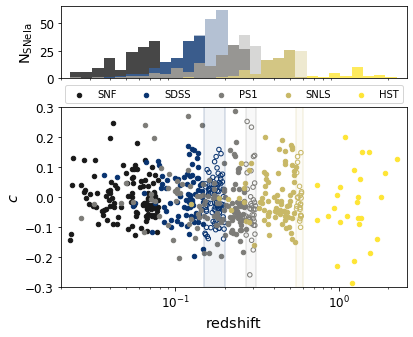

In [25]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
# for legend between
ax2 = fig.add_axes([0.1, 0.70, 0.6, 0.2])
# for legend down
#ax2 = fig.add_axes([0.1, 0.65, 0.6, 0.2])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)

alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)

prop = dict(marker="o", s=20, lw=1)

#_, vio_bins = np.histogram(dataz_all, histedges_equalN(dataz_all, 3))

for survey in surveys:
    df_ncused = df_nc[df_nc['survey'] == survey]
    df_cused = df_c[df_c['survey'] == survey]
    if btw.value:
        ax.scatter(z_zinfcuts[survey],
                   c_zinfcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
        ax.scatter(z_zbtwcuts[survey],
                   c_zbtwcuts[survey],
                   facecolors='none',
                   edgecolors=colors[survey],
                   **prop)
        
        ax.vline(z_max[survey][0],
                 color=colors[survey],
                 alpha=.1)
        ax.vline(z_max[survey][1],
                 color=colors[survey],
                 alpha=.1)
        ax.axvspan(z_max[survey][0],
                   z_max[survey][1],
                   color=colors[survey],
                   alpha=.05, lw=2.0)
        
    else:
        ax.scatter(z_zcuts[survey],
                   c_zcuts[survey],
                   color=colors[survey],
                   label=survey, **prop)
    
    if after.value:    
        ax.scatter(z_zsupcuts[survey],
                   c_zsupcuts[survey],
                   facecolors="None",
                   edgecolors=colors[survey],
                   **prop, alpha=.2)

test = np.array([[z_zinfcuts[survey], z_zbtwcuts[survey]] for survey in surveys])

it = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
stacked = np.array([test[i][k] for i,k in it])
hstclrs = [[list(alpha8colors.values())[i],
            list(alpha3colors.values())[i]] for i in range(5)]
hstclrs = [item for sublist in hstclrs for item in sublist]

order = [3, 2, 1, 0, 4]
stacked_bt = [test[i][0] for i in order] + [test[i][1] for i in order]
hstclrs_bt = [list(alpha8colors.values())[i] for i in order]\
           + [list(alpha3colors.values())[i] for i in order]

ax2.hist(stacked_bt,
         stacked=True,
         bins=10**np.linspace(np.log10(np.min(df_nc.redshifts)),
                              np.log10(np.max(df_nc.redshifts)), 30),
         histtype='stepfilled',
         color=hstclrs_bt)

ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$c$', fontsize = 'x-large')
ax2.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.set_xlim(0.02, 2.6)
# for legend between
ax.set_ylim(-0.3, 0.3)
# for legend down
#ax.set_ylim(-3.6, 3)
ax.set_xscale('log')

ax2.set_xlim(0.02, 2.6)
ax2.set_xscale('log')
ax2.get_xaxis().set_ticks([])

# for figsize(7,5), legend between
ax.legend(loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))
# for figsize(7,5), legend down
#ax.legend(loc='lower center', fontsize='medium', ncol=5)

path = '../../Images/pdf/colors-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.pdf'
fig.savefig(path, bbox_inches='tight')

path = '../../Images/png/colors-cut'
if cons.value:
    path = path + '_cons'
if btw.value:
    path = path + '_btw'
if after.value:
    path = path + '_sup'

path = path + '_hist_stac_75-lb-'+smap.name+'.png'
fig.savefig(path, bbox_inches='tight', dpi=600)

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$

### Définition des bins sur lesquels faire les moyennes

In [28]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(df_nc.redshifts, histedges_equalN(df_nc.redshifts, 6))
_, bins_cons = np.histogram(df_c.redshifts, histedges_equalN(df_c.redshifts, 6))

bins_text = bins.copy()
bins_text[-1] = 1.4
shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.012, 0.017],
                [0.015, 0.023],
                [0.029, 0.040],
                [0.180, 0.210]]

### Means for combined sample

In [29]:
slices = []
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
c_comp_mean = np.zeros(6)
c_comp_std = np.zeros(6)
    
slices_cons = []
z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)
x1_comp_mean_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
c_comp_mean_cons = np.zeros(6)
c_comp_std_cons = np.zeros(6)

slices_nHST = []
z_comp_mean_nHST = np.zeros(6)
z_comp_std_nHST = np.zeros(6)
x1_comp_mean_nHST = np.zeros(6)
x1_comp_std_nHST = np.zeros(6)
c_comp_mean_nHST = np.zeros(6)
c_comp_std_nHST = np.zeros(6)

slices_sup = []
z_comp_mean_sup = np.zeros(6)
z_comp_std_sup = np.zeros(6)
x1_comp_mean_sup = np.zeros(6)
x1_comp_std_sup = np.zeros(6)
c_comp_mean_sup = np.zeros(6)
c_comp_std_sup = np.zeros(6)

slices_full = []
z_comp_mean_full = np.zeros(6)
z_comp_std_full = np.zeros(6)
x1_comp_mean_full = np.zeros(6)
x1_comp_std_full = np.zeros(6)
c_comp_mean_full = np.zeros(6)
c_comp_std_full = np.zeros(6)

for i in range(6):
    slices.append(np.where((df_nc.redshifts > bins[i])
                         & (df_nc.redshifts <= bins[i+1]))[0])
    z_comp_mean[i]  = np.mean(df_nc.redshifts.values[slices[i]])
    z_comp_std[i]   = np.std(df_nc.redshifts.values[slices[i]])
    x1_comp_mean[i] = np.average(df_nc.stretchs.values[slices[i]],
                                 weights=1/(df_nc.stretchs_err.values[slices[i]])**2)
    x1_comp_std[i]  = np.std(df_nc.stretchs.values[slices[i]])
    c_comp_mean[i]  = np.average(df_nc.colors.values[slices[i]],
                                 weights=1/(df_nc.colors_err.values[slices[i]])**2)
    c_comp_std[i]   = np.std(df_nc.colors.values[slices[i]])
    
    slices_cons.append(np.where((df_c.redshifts > bins[i])
                                & (df_c.redshifts <= bins[i+1]))[0])
    z_comp_mean_cons[i]  = np.mean(df_c.redshifts.values[slices_cons[i]])
    z_comp_std_cons[i]   = np.std(df_c.redshifts.values[slices_cons[i]])
    x1_comp_mean_cons[i] = np.average(df_c.stretchs.values[slices_cons[i]],
                                     weights=1/(df_c.stretchs_err.values[slices_cons[i]])**2)
    x1_comp_std_cons[i]  = np.std(df_c.stretchs.values[slices_cons[i]])
    c_comp_mean_cons[i]  = np.average(df_c.colors.values[slices_cons[i]],
                                     weights=1/(df_c.colors_err.values[slices_cons[i]])**2)
    c_comp_std_cons[i]   = np.std(df_c.colors.values[slices_cons[i]])
    
    slices_nHST.append(np.where((df_nHST.redshifts > bins[i])
                              & (df_nHST.redshifts <= bins[i+1]))[0])
    z_comp_mean_nHST[i]  = np.mean(df_nHST.redshifts.values[slices_nHST[i]])
    z_comp_std_nHST[i]   = np.std(df_nHST.redshifts.values[slices_nHST[i]])
    x1_comp_mean_nHST[i] = np.average(df_nHST.stretchs.values[slices_nHST[i]],
                                      weights=1/(df_nHST.stretchs_err.values[slices_nHST[i]])**2)
    x1_comp_std_nHST[i]  = np.std(df_nHST.stretchs.values[slices_nHST[i]])
    c_comp_mean_nHST[i]  = np.average(df_nHST.colors.values[slices_nHST[i]],
                                      weights=1/(df_nHST.colors_err.values[slices_nHST[i]])**2)
    c_comp_std_nHST[i]   = np.std(df_nHST.colors.values[slices_nHST[i]]) 

    slices_full.append(np.where((df_full.redshifts > bins[i])
                              & (df_full.redshifts <= bins[i+1]))[0])
    z_comp_mean_full[i]  = np.mean(df_full.redshifts.values[slices_full[i]])
    z_comp_std_full[i]   = np.std(df_full.redshifts.values[slices_full[i]])
    x1_comp_mean_full[i] = np.average(df_full.stretchs.values[slices_full[i]],
                                      weights=1/(df_full.stretchs_err.values[slices_full[i]])**2)
    x1_comp_std_full[i]  = np.std(df_full.stretchs.values[slices_full[i]])
    c_comp_mean_full[i]  = np.average(df_full.colors.values[slices_full[i]],
                                     weights=1/(df_full.colors_err.values[slices_full[i]])**2)
    c_comp_std_full[i]   = np.std(df_full.colors.values[slices_full[i]])
    
    slices_sup.append(np.where((df_sup.redshifts > bins[i])
                              & (df_sup.redshifts <= bins[i+1]))[0])
    z_comp_mean_sup[i] = np.mean(df_sup.redshifts.values[slices_sup[i]])
    z_comp_std_sup[i] = np.std(df_sup.redshifts.values[slices_sup[i]])
    if len(slices_sup[i]) == 0:
        x1_comp_mean_sup[i] = np.mean(df_sup.stretchs.values[slices_sup[i]])
        c_comp_mean_sup[i] = np.mean(df_sup.colors.values[slices_sup[i]])
    else:
        x1_comp_mean_sup[i] = np.average(df_sup.stretchs.values[slices_sup[i]],
                                         weights=1/(df_sup.stretchs_err.values[slices_sup[i]])**2)
        c_comp_mean_sup[i] = np.average(df_sup.colors.values[slices_sup[i]],
                                         weights=1/(df_sup.colors_err.values[slices_sup[i]])**2)
    x1_comp_std_sup[i] = np.std(df_sup.stretchs.values[slices_sup[i]])
    c_comp_std_sup[i] = np.std(df_sup.colors.values[slices_sup[i]])

/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Means for samples binned

In [8]:
z_means = dict()
z_stds = dict()
x1_means = dict()
x1_stds = dict()
c_means = dict()
c_stds = dict()
xerrs = dict()
yerrs_c = dict()
yerrs_x = dict()

for survey in surveys:
    df_ncused = df_nc[df_nc['survey'] == survey]
    slicess = [np.where((df_ncused.redshifts > bins[i])
                      & (df_ncused.redshifts <= bins[i+1]))
               for i in range(6)]
    z_means[survey] = [np.mean(df_ncused.redshifts.values[slicess[i]]) for i in range(6)]
    z_stds[survey] = [np.std(df_ncused.redshifts.values[slicess[i]]) for i in range(6)]
    x1_means[survey] = [np.mean(df_ncused.stretchs.values[slicess[i]]) for i in range(6)]
    x1_stds[survey] = [np.std(df_ncused.stretchs.values[slicess[i]]) for i in range(6)]
    c_means[survey] = [np.mean(df_ncused.colors.values[slicess[i]]) for i in range(6)]
    c_stds[survey] = [np.std(df_ncused.colors.values[slicess[i]]) for i in range(6)]
    
    xerrs[survey] = np.asarray(z_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.redshifts.values[slicess[i]])) for i in range(6)])
    
    yerrs_c[survey] = np.asarray(c_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.colors.values[slicess[i]])) for i in range(6)])
    
    yerrs_x[survey] = np.asarray(x1_stds[survey])/\
    np.asarray([np.sqrt(len(df_ncused.stretchs.values[slicess[i]])) for i in range(6)])

## Tracé pour stretch

/home/nicolas/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


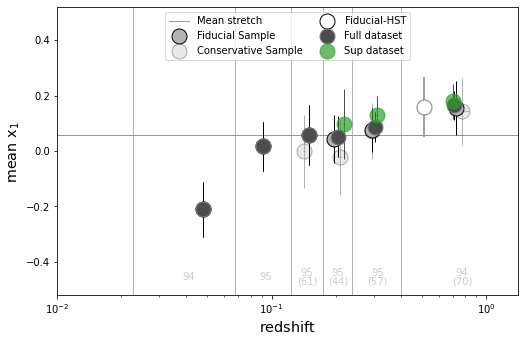

In [30]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop3 = dict(marker="o", ms=15, ecolor="k", mew=1, mec="C2", mfc='C2')
prop2 = dict(marker="o", ms=15, ecolor="k", mew=1, mec="0.5", mfc='.3')
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)
  
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], x1_means[survey],
#                xerr=xerrs[survey], yerr=yerrs_x[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax.errorbar(z_comp_mean_nHST[-1], x1_comp_mean_nHST[-1],
            xerr=z_comp_std_nHST[-1]/np.sqrt(len(df_nHST.redshifts.values[slices_nHST[-1]])),
            yerr=x1_comp_std_nHST[-1]/np.sqrt(len(df_nHST.stretchs.values[slices_nHST[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')
            #marker='o', ms=15, ecolor='k', mfc=None)
    
for i in range(6):
    ax.errorbar(z_comp_mean_full[i], x1_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=x1_comp_std_full[i]/np.sqrt(len(df_full.stretchs.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
    
for i in range(6):
    ax.errorbar(z_comp_mean_sup[i], x1_comp_mean_sup[i],
                xerr=z_comp_std_sup[i]/np.sqrt(len(df_sup.redshifts.values[slices_sup[i]])),
                yerr=x1_comp_std_sup[i]/np.sqrt(len(df_sup.stretchs.values[slices_sup[i]])),
                **prop3, zorder=10, lw=1,
                label='Sup dataset', alpha=.7)

legend_elements = [Line2D([0], [0], ls='-', color='C1', lw=1,
                          label='Mean stretch'),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7",
                          label='Fiducial Sample', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7", alpha=.3,
                          label='Conservative Sample', lw=0), 
                   Line2D([0], [0], marker='o', ms=15, mfc='white', mec='k',
                          label='Fiducial-HST', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="0.5", mfc="0.3",
                          label='Full dataset', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="C2", mfc="C2", alpha=.7,
                          label='Sup dataset', lw=0) ]

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                 xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                 yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                 color='g', **prop, alpha=.3, zorder=9, lw=1)

ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
#ax.set_ylim(-0.80, 0.60)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.legend(handles=legend_elements, ncol=2, loc='upper center', columnspacing=1.4)

fig.savefig('../../../Images/pdf/mean-weighted_stretchs-nhst_full-sup.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mean-weighted_stretchs-nhst_full-sup.png', bbox_inches='tight', dpi=600)

## Tracé pour color

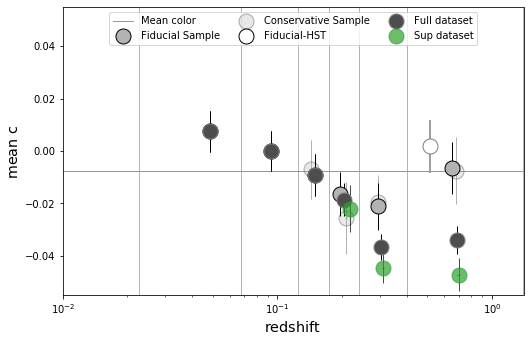

In [118]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="k", mew=1, mec="0.5", mfc='.3')
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)
    
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], c_means[survey],
#                xerr = xerrs[survey], yerr = yerrs_c[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean[i], c_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=c_comp_std[i]/np.sqrt(len(df_nc.colors.values[slices[i]])),
                **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax.errorbar(z_comp_mean_nhst[-1], c_comp_mean_nhst[-1],
            xerr=z_comp_std_nhst[-1]/np.sqrt(len(df_nhst.redshifts.values[slices_nhst[-1]])),
            yerr=c_comp_std_nhst[-1]/np.sqrt(len(df_nhst.colors.values[slices_nhst[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')

for i in range(6):
    ax.errorbar(z_comp_mean_full[i], c_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=c_comp_std_full[i]/np.sqrt(len(df_full.colors.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
        
for i in range(6):
    ax.errorbar(z_comp_mean_sup[i], c_comp_mean_sup[i],
                xerr=z_comp_std_sup[i]/np.sqrt(len(df_sup.redshifts.values[slices_sup[i]])),
                yerr=c_comp_std_sup[i]/np.sqrt(len(df_sup.colors.values[slices_sup[i]])),
                **prop3, zorder=10, lw=1,
                label='Sup dataset', alpha=.7)
    
legend_elements = [Line2D([0], [0], ls='-', color='C1', lw=1,
                          label='Mean color'),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7",
                          label='Fiducial Sample', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7", alpha=.3,
                          label='Conservative Sample', lw=0), 
                   Line2D([0], [0], marker='o', ms=15, mfc='white', mec='k',
                          label='Fiducial-HST', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="0.5", mfc="0.3",
                          label='Full dataset', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="C2", mfc="C2", alpha=.7,
                          label='Sup dataset', lw=0) ]

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean_cons[i], c_comp_mean_cons[i],
                 xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                 yerr = c_comp_std_cons[i]/np.sqrt(len(df_c.colors.values[slices_cons[i]])),
                 **prop, alpha=.3, zorder=9, lw=1)

ax.hline(np.mean(df_nc.colors), color='C1', lw=1, ls='-', label='Mean color')

#############################################################################################

#for i in range(6):
#    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465/13,
#                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
#    else:
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45/13,
#                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48/13,
#                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,c}$ ", fontsize="x-large")

#ax.set_ylim(-0.04, 0.04)
ax.set_ylim(-0.055, 0.055)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(handles=legend_elements, ncol=3, loc='upper center', columnspacing=1.6)

fig.savefig('../../Images/pdf/mean_colors-nHST_full-sup.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mean_colors-nHST_full-sup.png', bbox_inches='tight', dpi=600)

## Tracé combiné

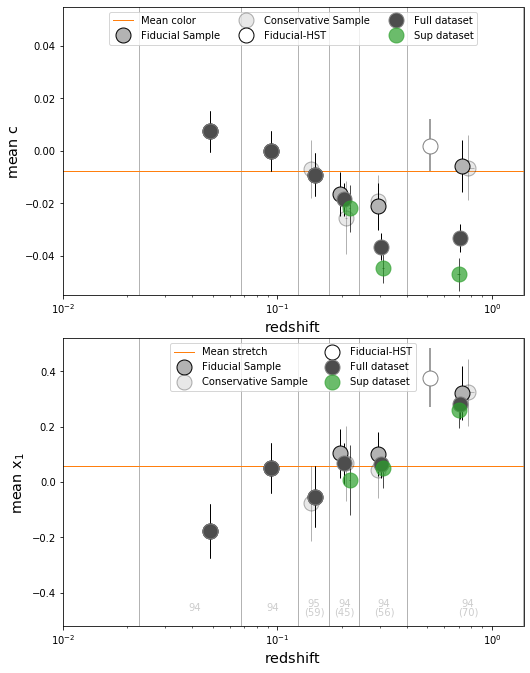

In [10]:
fig = plt.figure(figsize=[8, 10])
ax = fig.add_axes([0.1, 0.06, 0.8, 0.4])

prop3 = dict(marker="o", ms=15, ecolor="k", mew=1, mec="C2", mfc='C2')
prop2 = dict(marker="o", ms=15, ecolor="k", mew=1, mec="0.5", mfc='.3')
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)
  
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], x1_means[survey],
#                xerr=xerrs[survey], yerr=yerrs_x[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax.errorbar(z_comp_mean_nhst[-1], x1_comp_mean_nhst[-1],
            xerr=z_comp_std_nhst[-1]/np.sqrt(len(df_nhst.redshifts.values[slices_nhst[-1]])),
            yerr=x1_comp_std_nhst[-1]/np.sqrt(len(df_nhst.stretchs.values[slices_nhst[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')
            #marker='o', ms=15, ecolor='k', mfc=None)
    
for i in range(6):
    ax.errorbar(z_comp_mean_full[i], x1_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=x1_comp_std_full[i]/np.sqrt(len(df_full.stretchs.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
    
for i in range(6):
    ax.errorbar(z_comp_mean_sup[i], x1_comp_mean_sup[i],
                xerr=z_comp_std_sup[i]/np.sqrt(len(df_sup.redshifts.values[slices_sup[i]])),
                yerr=x1_comp_std_sup[i]/np.sqrt(len(df_sup.stretchs.values[slices_sup[i]])),
                **prop3, zorder=10, lw=1,
                label='Sup dataset', alpha=.7)

legend_elements = [Line2D([0], [0], ls='-', color='C1', lw=1,
                          label='Mean stretch'),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7",
                          label='Fiducial Sample', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7", alpha=.3,
                          label='Conservative Sample', lw=0), 
                   Line2D([0], [0], marker='o', ms=15, mfc='white', mec='k',
                          label='Fiducial-HST', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="0.5", mfc="0.3",
                          label='Full dataset', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="C2", mfc="C2", alpha=.7,
                          label='Sup dataset', lw=0) ]

#############################################################################################

for i in range(6):
    ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                 xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                 yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                 **prop, alpha=.3, zorder=9, lw=1)

ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
#ax.set_ylim(-0.80, 0.60)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.legend(handles=legend_elements, ncol=2, loc='upper center', columnspacing=1.4)

#############################################################################################
#############################################################################################

ax2 = fig.add_axes([0.1, 0.52, 0.8, 0.4])

for i in range(len(bins)):
    ax2.vline(bins[i], color="0.7", lw=1)
    
#############################################################################################

#for survey in surveys:
#    df_ncused = df_nc[df_nc['survey'] == survey]
#    ax.errorbar(z_means[survey], c_means[survey],
#                xerr = xerrs[survey], yerr = yerrs_c[survey],
#                marker='o', ms=15, color=colors[survey],
#                mew=1, mec='0.5', ls='None',
#                zorder=10, label=survey)

#############################################################################################

for i in range(6):
    ax2.errorbar(z_comp_mean[i], c_comp_mean[i],
                xerr=z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                yerr=c_comp_std[i]/np.sqrt(len(df_nc.colors.values[slices[i]])),
                **prop, zorder=10, lw=1,
                label='Fiducial sample')#, alpha=.3)

ax2.errorbar(z_comp_mean_nhst[-1], c_comp_mean_nhst[-1],
            xerr=z_comp_std_nhst[-1]/np.sqrt(len(df_nhst.redshifts.values[slices_nhst[-1]])),
            yerr=c_comp_std_nhst[-1]/np.sqrt(len(df_nhst.colors.values[slices_nhst[-1]])),
            color='gray', fmt='o', ms=15, mfc='white',
            label='Fiducial-HST')

for i in range(6):
    ax2.errorbar(z_comp_mean_full[i], c_comp_mean_full[i],
                xerr=z_comp_std_full[i]/np.sqrt(len(df_full.redshifts.values[slices_full[i]])),
                yerr=c_comp_std_full[i]/np.sqrt(len(df_full.colors.values[slices_full[i]])),
                **prop2, zorder=10, lw=1,
                label='Full dataset')#, alpha=.3)
        
for i in range(6):
    ax2.errorbar(z_comp_mean_sup[i], c_comp_mean_sup[i],
                xerr=z_comp_std_sup[i]/np.sqrt(len(df_sup.redshifts.values[slices_sup[i]])),
                yerr=c_comp_std_sup[i]/np.sqrt(len(df_sup.colors.values[slices_sup[i]])),
                **prop3, zorder=10, lw=1,
                label='Sup dataset', alpha=.7)
    
legend_elements = [Line2D([0], [0], ls='-', color='C1', lw=1,
                          label='Mean color'),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7",
                          label='Fiducial Sample', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="k", mfc="0.7", alpha=.3,
                          label='Conservative Sample', lw=0), 
                   Line2D([0], [0], marker='o', ms=15, mfc='white', mec='k',
                          label='Fiducial-HST', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="0.5", mfc="0.3",
                          label='Full dataset', lw=0),
                   Line2D([0], [0], marker="o", ms=15, mew=1, mec="C2", mfc="C2", alpha=.7,
                          label='Sup dataset', lw=0) ]

#############################################################################################

for i in range(6):
    ax2.errorbar(z_comp_mean_cons[i], c_comp_mean_cons[i],
                 xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                 yerr = c_comp_std_cons[i]/np.sqrt(len(df_c.colors.values[slices_cons[i]])),
                 **prop, alpha=.3, zorder=9, lw=1)

ax2.hline(np.mean(df_nc.colors), color='C1', lw=1, ls='-', label='Mean color')

#############################################################################################

#for i in range(6):
#    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465/13,
#                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
#    else:
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45/13,
#                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
#        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48/13,
#                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax2.set_ylabel(r"$\mathrm{mean\,\,c}$ ", fontsize="x-large")

#ax.set_ylim(-0.04, 0.04)
ax2.set_ylim(-0.055, 0.055)
ax2.set_xlim(0.01, 1.4)
ax2.set_xscale('log')

ax2.legend(handles=legend_elements, ncol=3, loc='upper center', columnspacing=1.6)

fig.savefig('../../Images/pdf/mean_both-nHST_full-sup.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mean_both-nHST_full-sup.png', bbox_inches='tight', dpi=600)

## $\delta(z)$ evolution

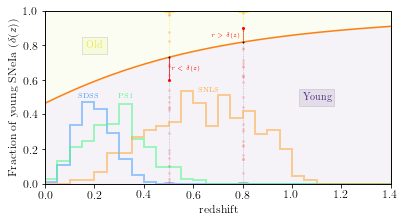

In [18]:
#######################################################################################
####################               Définition figure               ####################
#######################################################################################

fig = plt.figure(figsize=[6, 3])
ax = fig.add_axes([0.1, 0.15, 0.8, 0.8])
axt = ax.twinx()

#######################################################################################
####################               Définition deltaz               ####################
#######################################################################################

z_lin = np.linspace(0., 1.4, 1000)
deltaz = stretchevol.Evol2G2M2S.delta(z_lin)
ax.plot(z_lin, deltaz, color="C1")

#######################################################################################
####################               Définition zonesy               ####################
#######################################################################################

cmap = plt.cm.get_cmap('viridis')

ax.fill_between(z_lin, deltaz,
                color=cmap(0.1), alpha=.05)
ax.fill_between(z_lin, deltaz, 1,
                color=cmap(0.9), alpha=.05)

ax.text(0.2, 0.80, 'Old',
        va='center', ha='center',
        color=cmap(0.95), alpha=.7,
        bbox=dict(facecolor=cmap(0.95), alpha=0.1))
ax.text(1.1, 0.50, 'Young',
        va='center', ha='center',
        color=cmap(0.1),
        bbox=dict(facecolor=cmap(0.1), alpha=0.1))

#######################################################################################
####################               Définition rando1               ####################
#######################################################################################

#ax.axvline(0.5, ls='--', lw=.5, color='r', alpha=.3, solid_capstyle='projecting')
#err1 = ax.errorbar(0.5, 0.5, yerr=0.494,
#                   lw=.5, color='r', alpha=.3,
#                   capsize=5, barsabove=True)
#err1[-1][0].set_linestyle('--')
pl1, cl1, bl1 = ax.errorbar(0.5, stretchevol.Evol2G2M2S.delta(0.5)/2,
                            yerr=stretchevol.Evol2G2M2S.delta(0.5)/2-0.007,
                            lw=.5, color=cmap(0.1), alpha=.3,
                            capsize=5, barsabove=True)
bl1[0].set_linestyle('--')
cl1[1].set_marker(None)
pl1, cl1, bl1 = ax.errorbar(0.5, 0.5+stretchevol.Evol2G2M2S.delta(0.5)/2,
                            yerr=(1-stretchevol.Evol2G2M2S.delta(0.5))/2-0.007,
                            lw=.5, color=cmap(0.99), alpha=.7,
                            capsize=5, barsabove=True)
bl1[0].set_linestyle('--')
cl1[0].set_marker(None)

ax.plot(0.5, 0.6, 'ro', ms=2)
ax.plot(0.5, stretchevol.Evol2G2M2S.delta(0.5), 'ko', ms=1)
ax.plot([0.5, 0.5], [0.6, stretchevol.Evol2G2M2S.delta(0.5)],
        'r', lw=.7, zorder=1)
ax.text(0.51, 0.3+stretchevol.Evol2G2M2S.delta(0.5)/2, r'$r < \delta(z)$',
        ha='left', va='center', color='r', size='xx-small', zorder=10)
for i in range(25):
    ax.plot(0.5, np.random.random(), 'ro', ms=2, alpha=.1, zorder=7)

#######################################################################################
####################               Définition rando2               ####################
#######################################################################################

#ax.axvline(0.8, ls='--', lw=.5, color='r', alpha=.3)
#err2 = ax.errorbar(0.8, 0.8, yerr=0.494,
#                   lw=.5, color='r', alpha=.3,
#                   capsize=5, barsabove=True)
#err2[-1][0].set_linestyle('--')
pl2, cl2, bl2 = ax.errorbar(0.8, stretchevol.Evol2G2M2S.delta(0.8)/2,
                            yerr=stretchevol.Evol2G2M2S.delta(0.8)/2-0.007,
                            lw=.5, color=cmap(0.1), alpha=.3,
                            capsize=5, barsabove=True)
bl2[0].set_linestyle('--')
cl2[1].set_marker(None)
#cl2[1].set_color('k')
pl2, cl2, bl2 = ax.errorbar(0.8, 0.5+stretchevol.Evol2G2M2S.delta(0.8)/2,
                            yerr=(1-stretchevol.Evol2G2M2S.delta(0.8))/2-0.007,
                            lw=.5, color=cmap(0.99), alpha=.7,
                            capsize=5, barsabove=True)
bl2[0].set_linestyle('--')
cl2[0].set_marker(None)
#cl2[0].set_color('k')

ax.plot(0.8, 0.9, 'ro', ms=2)
ax.plot(0.8, stretchevol.Evol2G2M2S.delta(0.8), 'ko', ms=1)
ax.plot([0.8, 0.8], [stretchevol.Evol2G2M2S.delta(0.8), 0.9],
        'r', lw=.7, zorder=1)
ax.text(0.79, 0.45+stretchevol.Evol2G2M2S.delta(0.8)/2, r'$r > \delta(z)$',
        ha='right', va='center', color='r', size='xx-small', zorder=10)
for i in range(25):
    ax.plot(0.8, np.random.random(), 'ro', ms=2, alpha=.1, zorder=7)

#######################################################################################
####################               Définition axes1p               ####################
#######################################################################################

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize='large')
ax.set_ylabel(r'Fraction of young SNeIa $(\delta(z))$', fontsize='large')

ax.tick_params(labelsize='large')

ax.set_xlim(0, 1.4)
ax.set_ylim(0, 1.0)

#######################################################################################
####################               Définition histos               ####################
#######################################################################################

prop = dict(histtype='step', density=False, lw=2, alpha=.5, range=(0, 1.5), bins=30)

hmap = plt.cm.get_cmap('turbo')

axt.hist(df_full[df_full['survey'] == 'SDSS'].redshifts,
         color=hmap(0.2),
         weights=[0.5]*len(df_full[df_full['survey'] == 'SDSS'].redshifts),
         **prop)
axt.hist(df_full[df_full['survey'] == 'PS1'].redshifts,
         color=hmap(0.4),
         weights=[0.8]*len(df_full[df_full['survey'] == 'PS1'].redshifts),
         **prop)
axt.hist(df_full[df_full['survey'] == 'SNLS'].redshifts,
         color=hmap(0.7),
         weights=[2.0]*len(df_full[df_full['survey'] == 'SNLS'].redshifts),
         **prop)

axt.text(0.175, 46, 'SDSS', va='center', ha='center', color=hmap(0.2), size='x-small')
axt.text(0.325, 45, 'PS1',  va='center', ha='center', color=hmap(0.4), size='x-small')
axt.text(0.660, 49, 'SNLS', va='center', ha='center', color=hmap(0.7), size='x-small')

#######################################################################################
####################               Définition axes1p               ####################
#######################################################################################

axt.set_ylim(0, 90)
axt.set_yticks([])

fig.savefig('../../../Images/pdf/deltaz_hist_yo-random.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/deltaz_hist_yo-random.png', bbox_inches='tight', dpi=600)

In [7]:
deltaz = stretchevol.Evol2G2M2S.delta(z_lin)

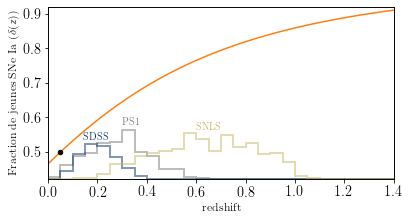

In [24]:
fig = plt.figure(figsize=[6, 3])
ax = fig.add_axes([0.1, 0.15, 0.8, 0.8])
axt = ax.twinx()

z_lin = np.linspace(0., 1.4, 1000)

ax.plot(z_lin, stretchevol.Evol2G2M2S.delta(z_lin), color="C1")

ax.set_xlabel('$\mathrm{redshift}$', fontsize='large')
ax.set_ylabel('Fraction de jeunes SNe~Ia $(\delta(z))$', fontsize='large')

ax.scatter(0.05, stretchevol.Evol1G1M1S.delta(0.05),
           color='k', s=20, zorder=3)

ax.set_xlim(0, 1.4)
ax.set_ylim(0.42, 0.92)

# ax.scatter([0.05, 1.30],
#            [stretchevol.Evol2G2M2S.delta(0.05), stretchevol.Evol2G2M2S.delta(1.30)],
#            marker='o', c='r', zorder=2)
# ax.plot([0.05, 0.05, 0.0],
#         [0.0, 0.5, 0.5], ls='--', c='r',
#         lw=0.6, alpha=0.7, dashes=(8, 10))
# ax.plot([1.30, 1.30, 0.0],
#         [0.0, 0.9, 0.9], ls='--', c='r',
#         lw=0.6, alpha=0.7, dashes=(8, 10))
# 
# ax.set_xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.3, 1.4])

prop = dict(histtype='step', density=False, lw=2, alpha=.5, range=(0, 1.5), bins=30)

axt.hist(df_full[df_full['survey'] == 'PS1'].redshifts,
         color=colors['PS1'],
         weights=[0.5]*len(df_full[df_full['survey'] == 'PS1'].redshifts),
         **prop)
axt.hist(df_full[df_full['survey'] == 'SDSS'].redshifts,
         color=colors['SDSS'],
         weights=[0.22]*len(df_full[df_full['survey'] == 'SDSS'].redshifts),
         **prop)
axt.hist(df_full[df_full['survey'] == 'SNLS'].redshifts,
         color=colors['SNLS'],
         **prop)
axt.set_ylim(0, 90)

axt.text(0.30, 27, 'PS1', va='bottom', ha='left', color=colors['PS1'])
axt.text(0.14, 20, 'SDSS', va='bottom', ha='left', color=colors['SDSS'])
axt.text(0.60, 25, 'SNLS', va='bottom', ha='left', color=colors['SNLS'])

axt.set_yticks([])

fig.savefig('../../../Images/pdf/deltaz_hist.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/deltaz_hist.png', bbox_inches='tight', dpi=600)